**Pronóstico de series de tiempo**

Para ésta actividad cambiare de estación climatologica por que la que tenia tiene miuchos huecos en los datos.
La estación nueva sera la 26068 que corresponde a la presa Alvaro Obregon.

In [1]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Paso 1:**

Tomar una serie de datos en un periodo sin huecos (Tmax, Tmin) de la estación que se está analizando, para probar si es una serie de tiempo estacionaria o hacer las transformaciones para convertirla en una. Ver el ejemplo mostrado en la Jupyter Notebook de esta actividad para realizar las acciones similares.

In [2]:
# Preparamos el Dataframe 
url = 'https://raw.githubusercontent.com/RaulACortez/FisicaComputacional1/main/FisicaComputacional1/Actividad6/26068.txt'

# Definimos los nombres de las columnas 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=20, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Convertimos los valores de las variables ambientales a números flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()
 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Agregamos las columnas Año y fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
df_datos = df_work2.copy()

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_datos_ts = df_datos.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_datos_ts = df_datos_ts.set_index('Fecha')

# Verificamos
df_datos_ts.info()
print(df_datos_ts.head())
print(df_datos_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_60 = df_datos_ts[(df_datos_ts['Año'] >= 1960) & (df_datos_ts['Año'] < 1990)]
df_90 = df_datos_ts[(df_datos_ts['Año'] >= 1990) & (df_datos_ts['Año'] < 2017)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24363 entries, 1949-05-20 to 2016-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  24363 non-null  float64
 1   Evap    24150 non-null  float64
 2   Tmax    24358 non-null  float64
 3   Tmin    24359 non-null  float64
 4   Año     24363 non-null  int64  
 5   Mes     24363 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
1949-05-20     0.0   NaN  40.5  13.0  1949  May
1949-05-21     0.0  13.1  41.5  13.5  1949  May
1949-05-22     0.0  11.7  42.0  13.5  1949  May
1949-05-23     0.0  11.5  40.0  15.5  1949  May
1949-05-24     0.0   8.4  40.5  17.5  1949  May
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
2016-09-26     0.0   6.9  38.0  21.0  2016  Sep
2016-09-27     0.0   5.9  37.0  24.0 

Definimos una función para probar la estacionaridad

In [4]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Creamos la primer serie de tiempo a analizar

In [6]:
start, end = '2008-01', '2013-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2008-01-01,0.0,3.3,24.5,11.0,2008,Jan
2008-01-02,0.0,4.3,26.0,11.5,2008,Jan
2008-01-03,0.0,3.8,27.0,13.5,2008,Jan
2008-01-04,0.0,4.2,26.0,14.0,2008,Jan
2008-01-05,0.0,3.8,29.0,15.0,2008,Jan


Veremos el encabezado

In [7]:
ts_90['Tmax'].head()

Fecha
2008-01-01    24.5
2008-01-02    26.0
2008-01-03    27.0
2008-01-04    26.0
2008-01-05    29.0
Name: Tmax, dtype: float64

Definimos la serie de Tiempo con Tmax que vamos a estudiar

In [11]:
ts_prueba = ts_90['Tmax'].copy()

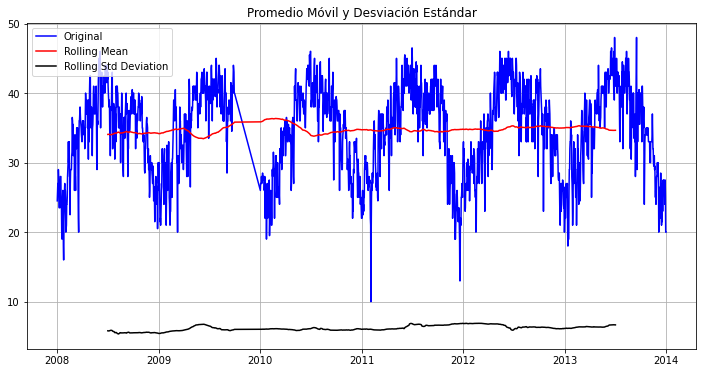

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.348748
p-value                           0.012835
#Lags Used                       13.000000
Number of Observations Used    2086.000000
Critical Value (1%)              -3.433489
Critical Value (5%)              -2.862927
Critical Value (10%)             -2.567508
dtype: float64


In [12]:
test_stationarity(ts_prueba)

Seleccionamos la función logaritmo y graficamos

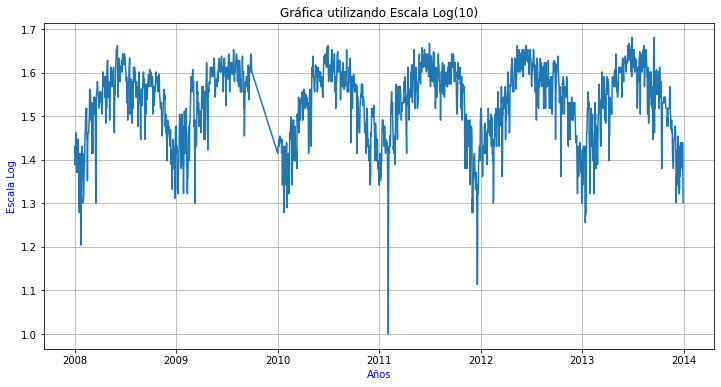

In [17]:
ts_prueba_log = np.log10(ts_test)
plt.plot(ts_prueba_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

Vamos a calcular el promedio móvil de ts_prueba_log con ventana de 365 y graficar para ver el contraste con la de arriba.

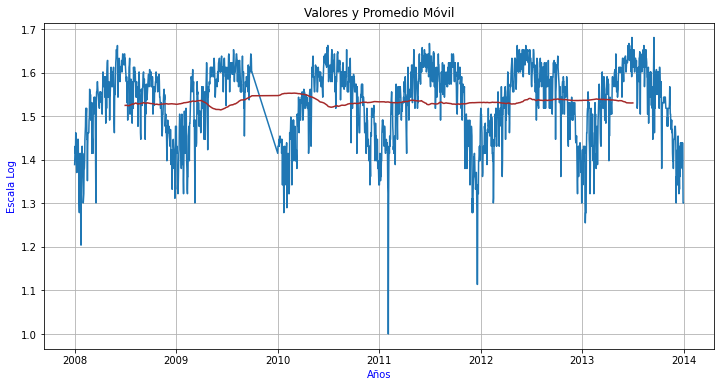

In [18]:
moving_avg = ts_prueba_log.rolling(365, center=True).mean()
plt.plot(ts_prueba_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [21]:
ts_prueba_log_moving_ave_diff = ts_prueba_log - moving_avg 
ts_prueba_log_moving_ave_diff.head()

Fecha
2008-01-01   NaN
2008-01-02   NaN
2008-01-03   NaN
2008-01-04   NaN
2008-01-05   NaN
Name: Tmax, dtype: float64

In [22]:
ts_prueba_log_moving_ave_diff.dropna(inplace=True)
ts_prueba_log_moving_ave_diff.head()

Fecha
2008-07-01    0.108308
2008-07-02    0.087508
2008-07-03    0.076614
2008-07-04    0.065663
2008-07-05    0.054337
Name: Tmax, dtype: float64

Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log

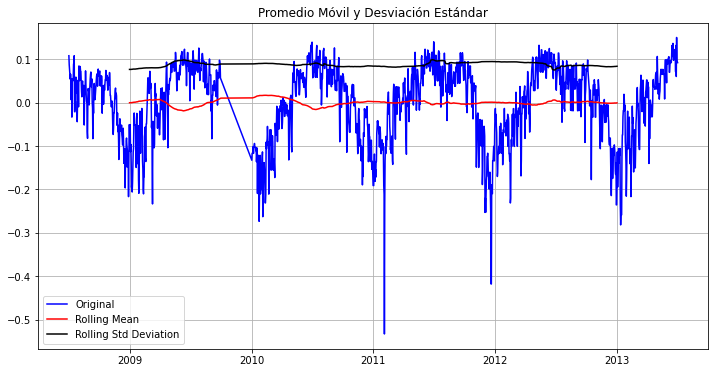

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.059300
p-value                           0.029715
#Lags Used                       15.000000
Number of Observations Used    1720.000000
Critical Value (1%)              -3.434158
Critical Value (5%)              -2.863222
Critical Value (10%)             -2.567665
dtype: float64


In [23]:
test_stationarity(ts_prueba_log_moving_ave_diff)

Aún la serie de tiempo no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial, función de pandas pd.ewm()

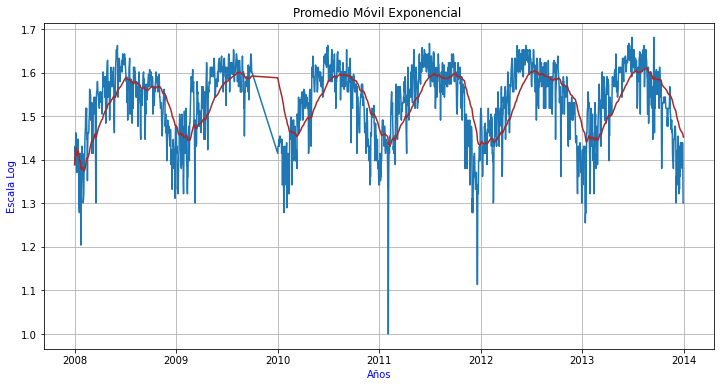

In [24]:
EWM_avg = ts_prueba_log.ewm(halflife=30).mean()
plt.plot(ts_prueba_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [25]:
EWM_avg.head()

Fecha
2008-01-01    1.389166
2008-01-02    1.402219
2008-01-03    1.412159
2008-01-04    1.412887
2008-01-05    1.423252
Name: Tmax, dtype: float64

Probamos la estacionarida de la diferencia

In [26]:
ts_prueba_log_EWM_avg_diff = ts_prueba_log - EWM_avg

Ahora probamos la estacionaridad de la nueva serie de tiempo

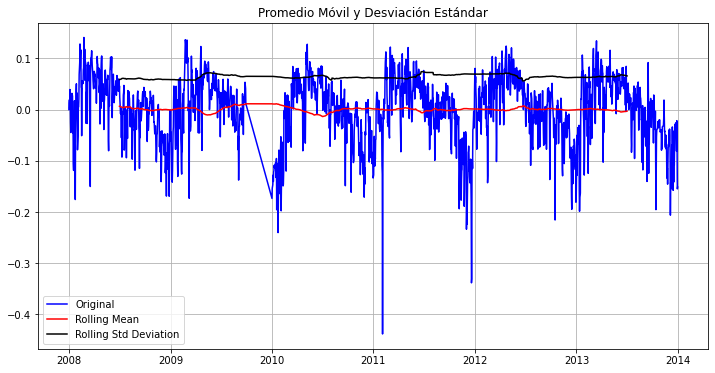

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.933349
p-value                           0.000030
#Lags Used                       13.000000
Number of Observations Used    2086.000000
Critical Value (1%)              -3.433489
Critical Value (5%)              -2.862927
Critical Value (10%)             -2.567508
dtype: float64


In [27]:
test_stationarity(ts_prueba_log_EWM_avg_diff)

Diferenciamos usando la función df.shift()

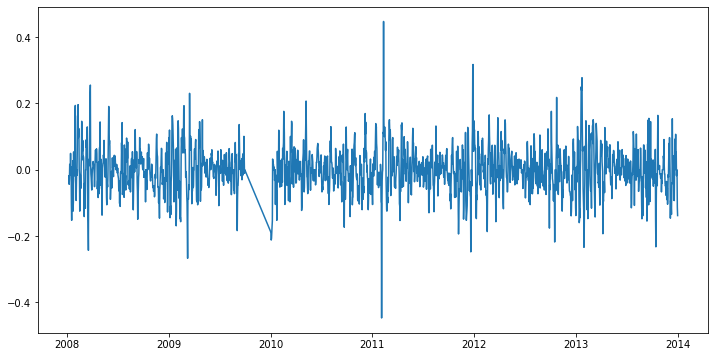

In [28]:
ts_prueba_log_diff = ts_prueba_log - ts_prueba_log.shift(periods=7)
plt.plot(ts_prueba_log_diff);

Probamos la estacionaridad

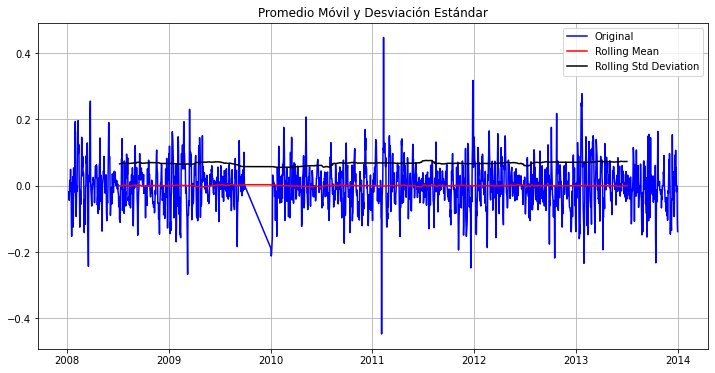

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.043586e+01
p-value                        1.567084e-18
#Lags Used                     2.100000e+01
Number of Observations Used    2.071000e+03
Critical Value (1%)           -3.433511e+00
Critical Value (5%)           -2.862937e+00
Critical Value (10%)          -2.567513e+00
dtype: float64


In [29]:
ts_prueba_log_diff.dropna(inplace=True)
test_stationarity(ts_prueba_log_diff)

Podemos decir que es estacionaria ya que el valor p < 0.05 y la desviación estándar no varía mucho.

Número de datos utilizados

In [31]:
len(ts_prueba_log_diff)

2093

Veamos el siguiente método de descomposición que utilzamos en la actividad anterior.

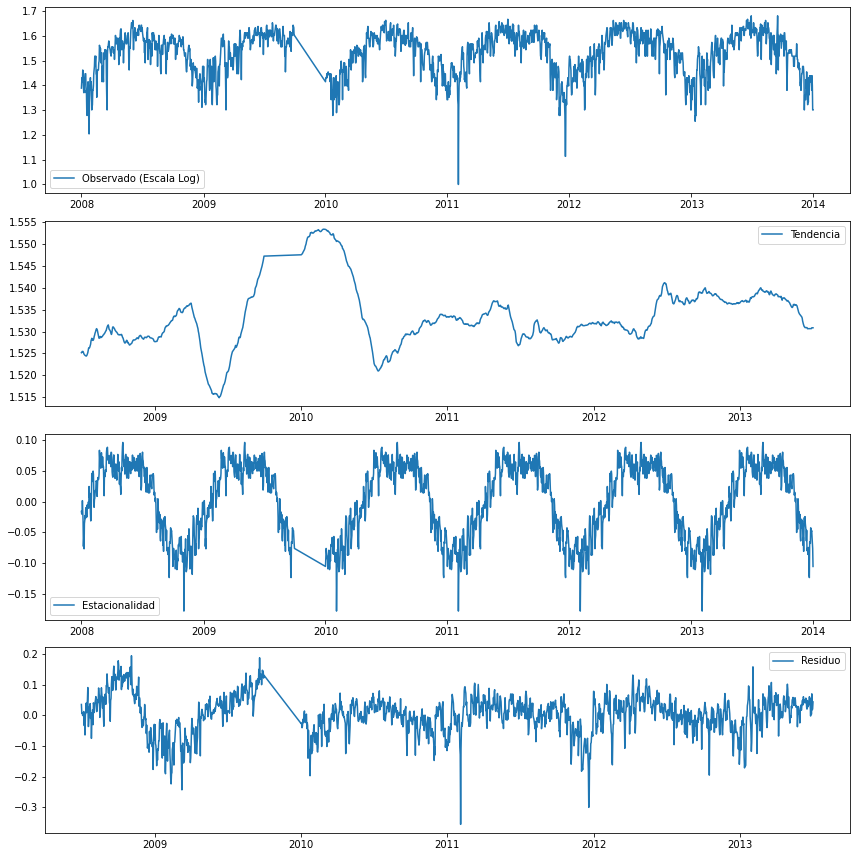

In [33]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_prueba_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_prueba_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

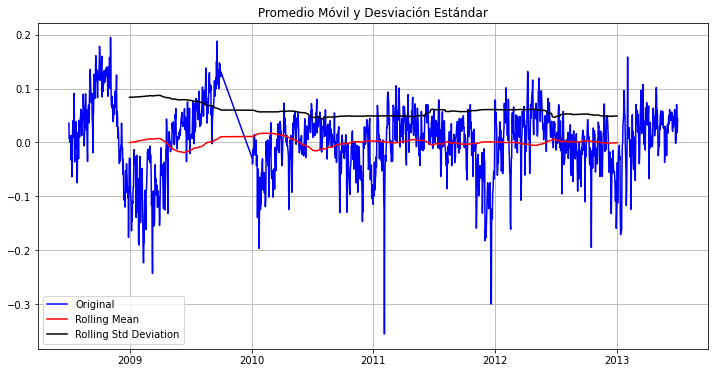

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.307865
p-value                           0.000430
#Lags Used                       13.000000
Number of Observations Used    1722.000000
Critical Value (1%)              -3.434153
Critical Value (5%)              -2.863220
Critical Value (10%)             -2.567664
dtype: float64


In [35]:
ts_prueba_log_decompose = residue 
ts_prueba_log_decompose.dropna(inplace=True)
test_stationarity(ts_prueba_log_decompose)

Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (0.00043).

Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.

Utilizaremos el método ARIMA.

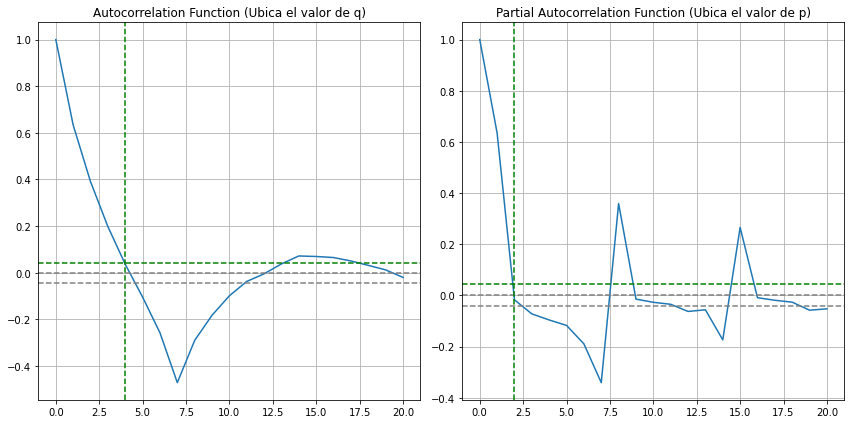

In [36]:
# Aplicamos ARIMA

lag_acf = acf(ts_prueba_log_diff, nlags=20)
lag_pacf = pacf(ts_prueba_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_prueba_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_prueba_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_prueba_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_prueba_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

**Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2099
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3833.195
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 12 Mar 2021   AIC                          -7658.389
Time:                        03:24:24   BIC                          -7635.792
Sample:                             1   HQIC                         -7650.112
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.131e-05      0.001     -0.063      0.950      -0.001       0.001
ar.L1.D.Tmax    -0.1827      0.022     -8.434      0.000      -0.225      -0.140
ar.L2.D.Tmax    -0.1211      0.022     -5.58

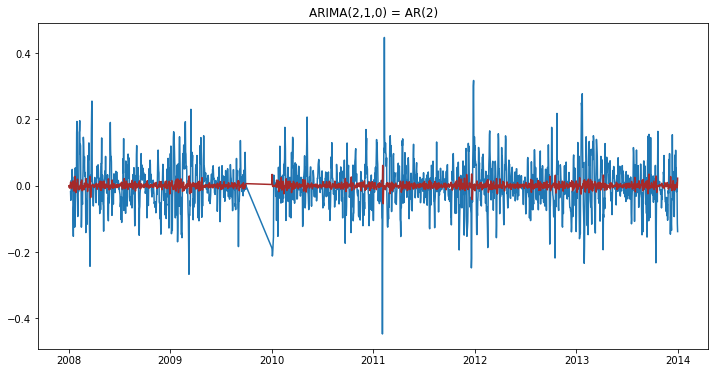

In [37]:
model = ARIMA(ts_prueba_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_prueba_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

**Modelo MA (Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2099
Model:                 ARIMA(0, 1, 4)   Log Likelihood                3916.451
Method:                       css-mle   S.D. of innovations              0.037
Date:                Fri, 12 Mar 2021   AIC                          -7820.902
Time:                        03:25:41   BIC                          -7787.007
Sample:                             1   HQIC                         -7808.487
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.709e-05      0.000     -0.075      0.940      -0.000       0.000
ma.L1.D.Tmax    -0.2778      0.022    -12.876      0.000      -0.320      -0.236
ma.L2.D.Tmax    -0.1754      0.022     -7.97

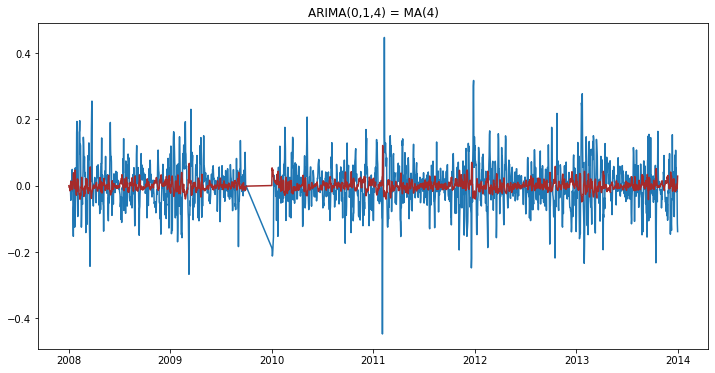

In [38]:
model = ARIMA(ts_prueba_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_prueba_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

**Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2099
Model:                 ARIMA(2, 1, 4)   Log Likelihood                3924.403
Method:                       css-mle   S.D. of innovations              0.037
Date:                Fri, 12 Mar 2021   AIC                          -7832.807
Time:                        03:26:43   BIC                          -7787.613
Sample:                             1   HQIC                         -7816.253
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.811e-05      0.000     -0.095      0.924      -0.001       0.001
ar.L1.D.Tmax     1.5881      0.060     26.471      0.000       1.470       1.706
ar.L2.D.Tmax    -0.6081      0.059    -10.39

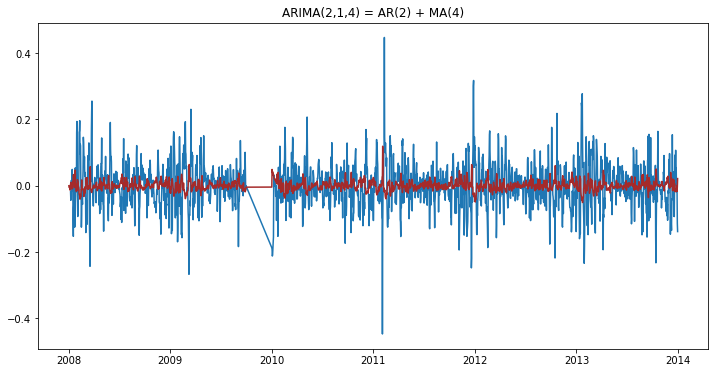

In [39]:
model = ARIMA(ts_prueba_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_prueba_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA

In [40]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2008-01-02   -0.000028
2008-01-03   -0.004250
2008-01-04   -0.006164
2008-01-05   -0.002569
2008-01-06   -0.013116
                ...   
2013-12-27   -0.010531
2013-12-28   -0.000577
2013-12-29   -0.017148
2013-12-30   -0.003116
2013-12-31    0.021554
Length: 2099, dtype: float64


Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)

In [41]:
predictions_ARIMA_log = pd.Series(ts_prueba_log, index = ts_prueba_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2008-01-01         NaN
2008-01-02    1.414945
2008-01-03    1.427113
2008-01-04    1.408810
2008-01-05    1.459829
dtype: float64
Fecha
2013-12-27    1.369680
2013-12-28    1.438755
2013-12-29    1.380792
2013-12-30    1.297914
2013-12-31    1.322584
dtype: float64


El siguiente paso es tomar el anti-logaritmo de log(Tmax), usamos la función 10**log(Tmax).

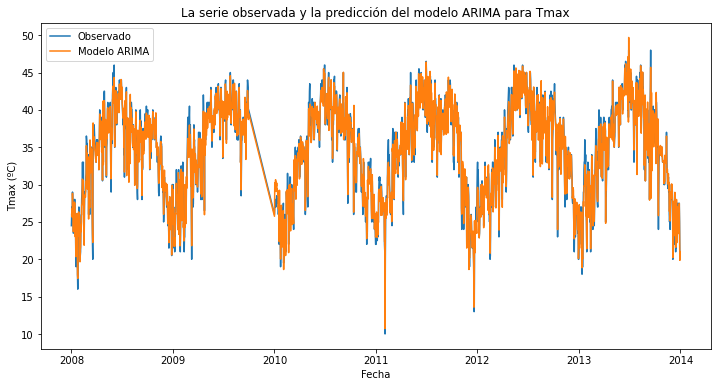

In [42]:
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_prueba, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

In [43]:
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_prueba)**2))
print('RMSE:', RMSE)

RMSE: 1.0076830247141502


Graficamos sólo los útimos datos de las series 

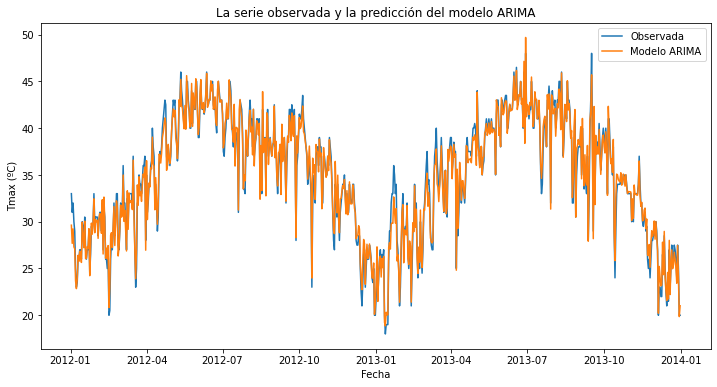

In [44]:
ts_prueba_last = ts_prueba.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_prueba_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');